### STATIC HAZARD & EXPOSURE BASELINE

### srtm

In [1]:
import rasterio
with rasterio.open("/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/srtm_52_09.tif") as ds:
    print(ds.crs)


EPSG:4326


In [2]:
import rasterio

tif_path = "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/srtm_52_09.tif"

with rasterio.open(tif_path) as ds:
    print("Driver       :", ds.driver)
    print("CRS          :", ds.crs)
    print("Width x Height:", ds.width, "x", ds.height)
    print("Bounds       :", ds.bounds)
    print("Resolution   :", ds.res)
    print("Data type    :", ds.dtypes)
    print("NoData value :", ds.nodata)


Driver       : GTiff
CRS          : EPSG:4326
Width x Height: 6000 x 6000
Bounds       : BoundingBox(left=75.0, bottom=15.0, right=80.0, top=20.0)
Resolution   : (0.0008333333333333334, 0.0008333333333333334)
Data type    : ('int16',)
NoData value : -32768.0


In [4]:
import rasterio
import numpy as np

tif_path = "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/srtm_52_09.tif"
out_path = "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/dem_hyderabad.npy"

with rasterio.open(tif_path) as ds:
    dem = ds.read(1)
    nodata = ds.nodata

# Mask nodata
dem = np.where(dem == nodata, np.nan, dem)

np.save(out_path, dem)

print("Saved:", out_path)
print("Shape:", dem.shape)
print("Min/Max:", np.nanmin(dem), np.nanmax(dem))


Saved: /vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/dem_hyderabad.npy
Shape: (6000, 6000)
Min/Max: 0.0 1106.0


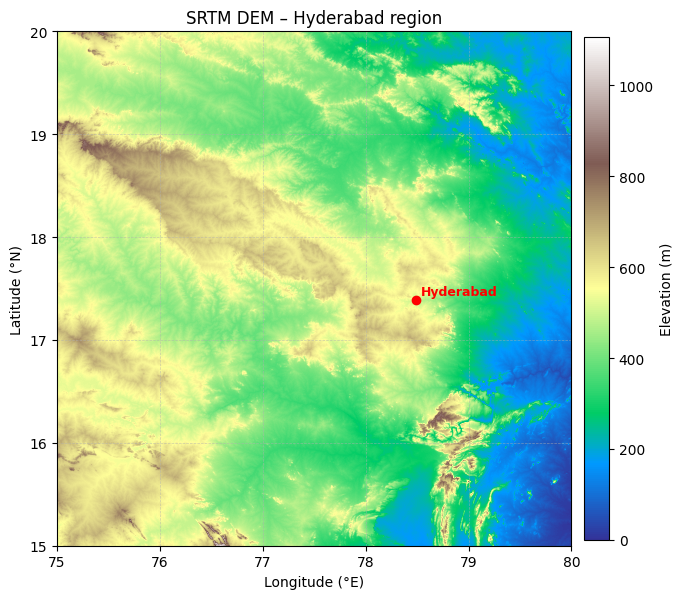

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load DEM
dem = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/dem_hyderabad.npy"
)

# Geographic extent
lon_min, lon_max = 75.0, 80.0
lat_min, lat_max = 15.0, 20.0

# Hyderabad coordinates
hyd_lon = 78.4867
hyd_lat = 17.3850

fig, ax = plt.subplots(figsize=(7, 7))

im = ax.imshow(
    dem,
    cmap="terrain",
    extent=[lon_min, lon_max, lat_min, lat_max],
    origin="upper"
)

# Colorbar (shorter height)
cbar = plt.colorbar(
    im,
    ax=ax,
    shrink=0.75,        # <-- controls height
    pad=0.02
)
cbar.set_label("Elevation (m)")

# Mark Hyderabad
ax.plot(
    hyd_lon,
    hyd_lat,
    marker="o",
    color="red",
    markersize=6,
    label="Hyderabad"
)

ax.text(
    hyd_lon + 0.05,
    hyd_lat + 0.05,
    "Hyderabad",
    color="red",
    fontsize=9,
    weight="bold"
)

# Labels and title
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_title("SRTM DEM – Hyderabad region")

# Gridlines
ax.grid(
    True,
    linestyle="--",
    linewidth=0.5,
    alpha=0.6
)

#ax.legend(loc="lower left")

plt.tight_layout()
plt.show()


In [8]:
import numpy as np
from scipy.ndimage import uniform_filter

# ============================================================
# 1. LOAD DEM
# ============================================================

dem_path = "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/dem_hyderabad.npy"

dem = np.load(dem_path).astype(np.float32)

print("DEM loaded")
print("Shape:", dem.shape)
print("Elevation range (m):", dem.min(), dem.max())

# ============================================================
# 2. GRID RESOLUTION (from SRTM metadata)
# ============================================================

# Degrees (~90 m)
dx = 0.0008333333333333334
dy = 0.0008333333333333334

# ============================================================
# 3. SLOPE & ASPECT (PHYSICS-BASED DERIVATIVES)
# ============================================================

# Gradients
dz_dy, dz_dx = np.gradient(dem, dy, dx)

# Slope
slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
slope_deg = np.degrees(slope_rad)

# Aspect
aspect_rad = np.arctan2(-dz_dx, dz_dy)
aspect_deg = np.degrees(aspect_rad)
aspect_deg = (aspect_deg + 360) % 360

print("Slope & aspect computed")

# ============================================================
# 4. ELEVATION NORMALIZATION (ML-READY)
# ============================================================

# (a) Min–Max normalization
elev_min = np.nanmin(dem)
elev_max = np.nanmax(dem)
elev_norm_minmax = (dem - elev_min) / (elev_max - elev_min)

# (b) Z-score normalization
elev_mean = np.nanmean(dem)
elev_std = np.nanstd(dem)
elev_norm_z = (dem - elev_mean) / elev_std

# (c) Relative elevation (local relief)
# ~5 km neighborhood (≈ 60 pixels at 90 m)
window = 60
elev_local_mean = uniform_filter(dem, size=window)
elev_relative = dem - elev_local_mean

print("Elevation normalization completed")
print("Elevation mean/std:", elev_mean, elev_std)

# ============================================================
# 5. FEATURE STACK (MODEL INPUT TENSOR)
# ============================================================

# Normalize aspect to [0, 1] for ML
aspect_norm = aspect_deg / 360.0

terrain_features = np.stack(
    [
        elev_norm_z,     # normalized elevation
        slope_deg,       # slope (degrees)
        aspect_norm,     # aspect (normalized)
        elev_relative    # relative elevation
    ],
    axis=0
)

print("Final terrain feature tensor shape:", terrain_features.shape)

# ============================================================
# 6. SAVE ALL OUTPUTS
# ============================================================

out_dir = "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/"

np.save(out_dir + "slope_deg.npy", slope_deg)
np.save(out_dir + "aspect_deg.npy", aspect_deg)
np.save(out_dir + "elev_norm_minmax.npy", elev_norm_minmax)
np.save(out_dir + "elev_norm_z.npy", elev_norm_z)
np.save(out_dir + "elev_relative.npy", elev_relative)
np.save(out_dir + "terrain_features.npy", terrain_features)

print("All DEM derivative products saved successfully")


DEM loaded
Shape: (6000, 6000)
Elevation range (m): 0.0 1106.0
Slope & aspect computed
Elevation normalization completed
Elevation mean/std: 429.30573 156.71223
Final terrain feature tensor shape: (4, 6000, 6000)
All DEM derivative products saved successfully


-----

### hydro basins

In [9]:
import geopandas as gpd

hybas_path = "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/hybas_as_lev08_v1c/hybas_as_lev08_v1c.shp"

basins = gpd.read_file(hybas_path)

print("CRS:", basins.crs)
print("Total basins:", len(basins))
basins.head()


CRS: EPSG:4326
Total basins: 28907


,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry
0,4080000010,0,4080000010,4080000010,0.0,0.0,892.0,892.0,42101000,0,1,0,1,"POLYGON ((135.5875 55.1, 135.58661 55.09654, 1..."
1,4080000080,0,4080000080,4080000080,0.0,0.0,273.2,2796.0,42102001,0,0,1,2,"POLYGON ((135.20417 55.14583, 135.2036 55.1522..."
2,4080082530,4080000080,4080000080,4080000080,30.0,30.0,117.8,1386.0,42102003,0,0,1,3,"POLYGON ((135.14167 55.1875, 135.12674 55.1878..."
3,4080082540,4080000080,4080000080,4080000080,30.0,30.0,1136.9,1136.9,42102002,0,0,2,4,"MULTIPOLYGON (((135.27083 55.30417, 135.26962 ..."
4,4080082200,4080082530,4080000080,4080000080,39.6,39.6,1.3,1157.2,42102005,0,0,1,5,"POLYGON ((135.18333 55.30417, 135.17917 55.304..."


In [10]:
from shapely.geometry import Point

# Hyderabad point
hyd_pt = Point(78.4867, 17.3850)

# Ensure same CRS
basins = basins.to_crs(epsg=4326)

# Find basin containing Hyderabad
musi_basin = basins[basins.contains(hyd_pt)]

print("Musi basin found:", len(musi_basin))
musi_basin


Musi basin found: 1


,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry
16571,4081083970,4081083900,4080027940,4080027940,411.7,411.7,1160.3,3402.3,45362070,0,0,2,16572,"POLYGON ((78.70833 17.35, 78.70591 17.34965, 7..."


In [11]:
out_path = "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
musi_basin.to_file(out_path)

print("Saved Musi basin to:", out_path)


Saved Musi basin to: /vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp


In [12]:
musi_basin.bounds


,minx,miny,maxx,maxy
16571,78.354167,17.229167,78.904167,17.588067


### hydrorivers

In [5]:
import geopandas as gpd

rivers = gpd.read_file("/vol/sandeep_storage/Files2/catastrophe/hydrorivers/HydroRIVERS_v10_as_shp/HydroRIVERS_v10_as.shp")
print(rivers.crs)
print(rivers.columns)
print(len(rivers))


EPSG:4326
Index(['HYRIV_ID', 'NEXT_DOWN', 'MAIN_RIV', 'LENGTH_KM', 'DIST_DN_KM',
       'DIST_UP_KM', 'CATCH_SKM', 'UPLAND_SKM', 'ENDORHEIC', 'DIS_AV_CMS',
       'ORD_STRA', 'ORD_CLAS', 'ORD_FLOW', 'HYBAS_L12', 'geometry'],
      dtype='object')
1428959


In [7]:
rivers = rivers[[
    "HYRIV_ID",
    "ORD_FLOW",
    "DIS_AV_CMS",
    "geometry"
]]


In [8]:
rivers.to_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/hydrorivers_clean.geojson",
    driver="GeoJSON"
)


### osm waste facilities

In [6]:
osm = gpd.read_file("/vol/sandeep_storage/Files2/catastrophe/osm/export.geojson")
print(osm.crs)
print(osm.columns)
print(osm.geom_type.value_counts())


EPSG:4326
Index(['id', '@id', 'addr:city', 'amenity', 'landuse', 'man_made', 'name',
       'opening_hours', 'operator', 'wheelchair', '@geometry', 'geometry'],
      dtype='object')
Point    16
Name: count, dtype: int64


In [9]:
osm["geometry"] = osm.geometry.centroid


/tmp/ipykernel_162192/2315576506.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  osm["geometry"] = osm.geometry.centroid


In [10]:
def classify_facility(row):
    if row["landuse"] == "landfill":
        return "landfill"
    if row["amenity"] == "recycling":
        return "recycling"
    if row["amenity"] == "waste_transfer_station":
        return "transfer_station"
    if row["man_made"] == "wastewater_plant":
        return "wastewater_plant"
    return "other"

osm["facility_type"] = osm.apply(classify_facility, axis=1)


In [11]:
osm = osm[[
    "facility_type",
    "geometry"
]]


In [12]:
osm.to_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_clean.geojson",
    driver="GeoJSON"
)


### population


In [1]:
import rasterio
with rasterio.open("/vol/sandeep_storage/Files2/catastrophe/pop/ind_ppp_2020_UNadj.tif") as ds:
    print(ds.crs)


EPSG:4326


In [2]:


tif_path = "/vol/sandeep_storage/Files2/catastrophe/pop/ind_ppp_2020_UNadj.tif"

with rasterio.open(tif_path) as ds:
    print("Driver       :", ds.driver)
    print("CRS          :", ds.crs)
    print("Width x Height:", ds.width, "x", ds.height)
    print("Bounds       :", ds.bounds)
    print("Resolution   :", ds.res)
    print("Data type    :", ds.dtypes)
    print("NoData value :", ds.nodata)


Driver       : GTiff
CRS          : EPSG:4326
Width x Height: 35075 x 34497
Bounds       : BoundingBox(left=68.185416408, bottom=6.753750174, right=97.414582958, top=35.501250059)
Resolution   : (0.0008333333300071276, 0.0008333333299997101)
Data type    : ('float32',)
NoData value : -99999.0


In [3]:

import numpy as np

tif_path = "/vol/sandeep_storage/Files2/catastrophe/pop/ind_ppp_2020_UNadj.tif"
out_path = "/vol/sandeep_storage/Files2/catastrophe/pop/ind_ppp_2020_UNadj.npy"

with rasterio.open(tif_path) as ds:
    dem = ds.read(1)
    nodata = ds.nodata

# Mask nodata
dem = np.where(dem == nodata, np.nan, dem)

np.save(out_path, dem)

print("Saved:", out_path)
print("Shape:", dem.shape)
print("Min/Max:", np.nanmin(dem), np.nanmax(dem))


Saved: /vol/sandeep_storage/Files2/catastrophe/pop/ind_ppp_2020_UNadj.npy
Shape: (34497, 35075)
Min/Max: 0.0 2355.0823


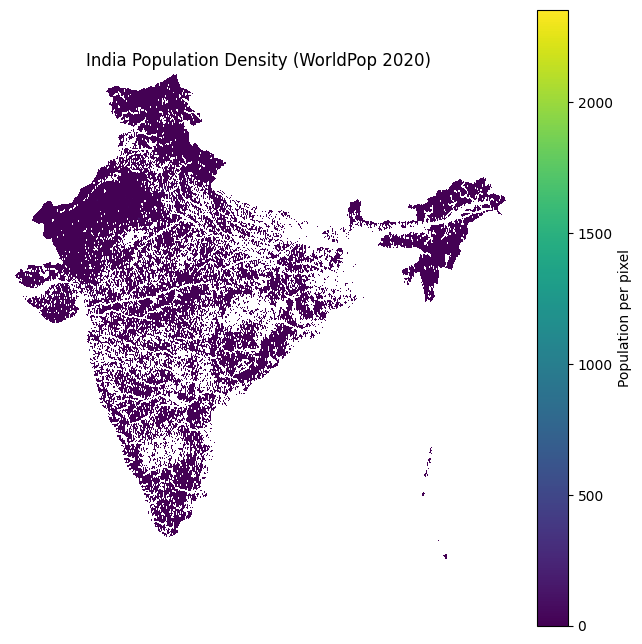

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved numpy array
pop = np.load("/vol/sandeep_storage/Files2/catastrophe/pop/ind_ppp_2020_UNadj.npy")

plt.figure(figsize=(8, 8))
plt.imshow(pop, cmap="viridis")
plt.colorbar(label="Population per pixel")
plt.title("India Population Density (WorldPop 2020)")
plt.axis("off")
plt.show()


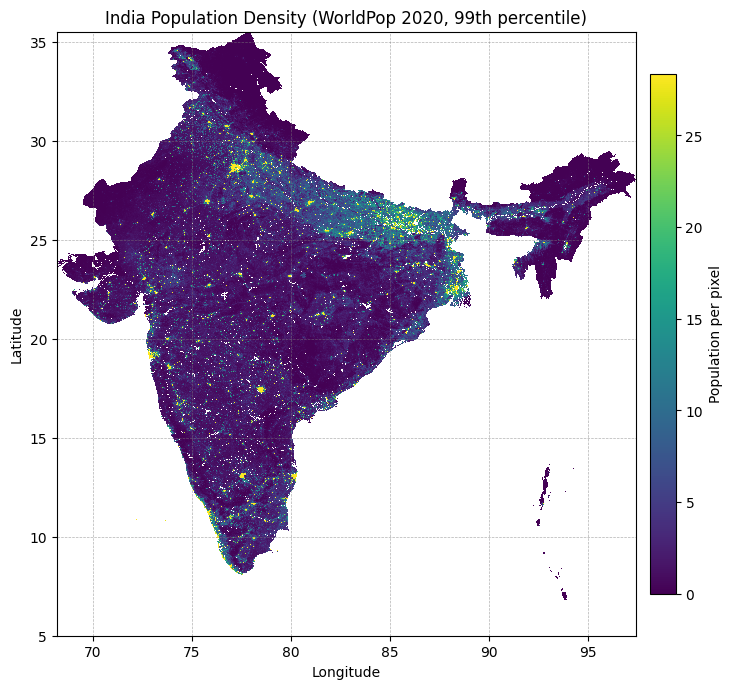

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load population data (NO flipping)
pop = np.load("/vol/sandeep_storage/Files2/catastrophe/pop/ind_ppp_2020_UNadj.npy")

# Geographic extent (lon_min, lon_max, lat_min, lat_max)
extent = [68.185416408, 97.414582958, 6.753750174, 35.501250059]

# Robust scaling
vmax = np.nanpercentile(pop, 99)

fig, ax = plt.subplots(figsize=(9, 9))

img = ax.imshow(
    pop,
    extent=extent,
    cmap="viridis",
    vmin=0,
    vmax=vmax,
    origin="upper",      
    interpolation="nearest"
)

# Smaller colorbar
cbar = fig.colorbar(
    img,
    ax=ax,
    shrink=0.75,         # ↓ size
    pad=0.02
)
cbar.set_label("Population per pixel")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("India Population Density (WorldPop 2020, 99th percentile)")

ax.set_xticks(np.arange(70, 100, 5))
ax.set_yticks(np.arange(5, 40, 5))
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.6)

plt.show()


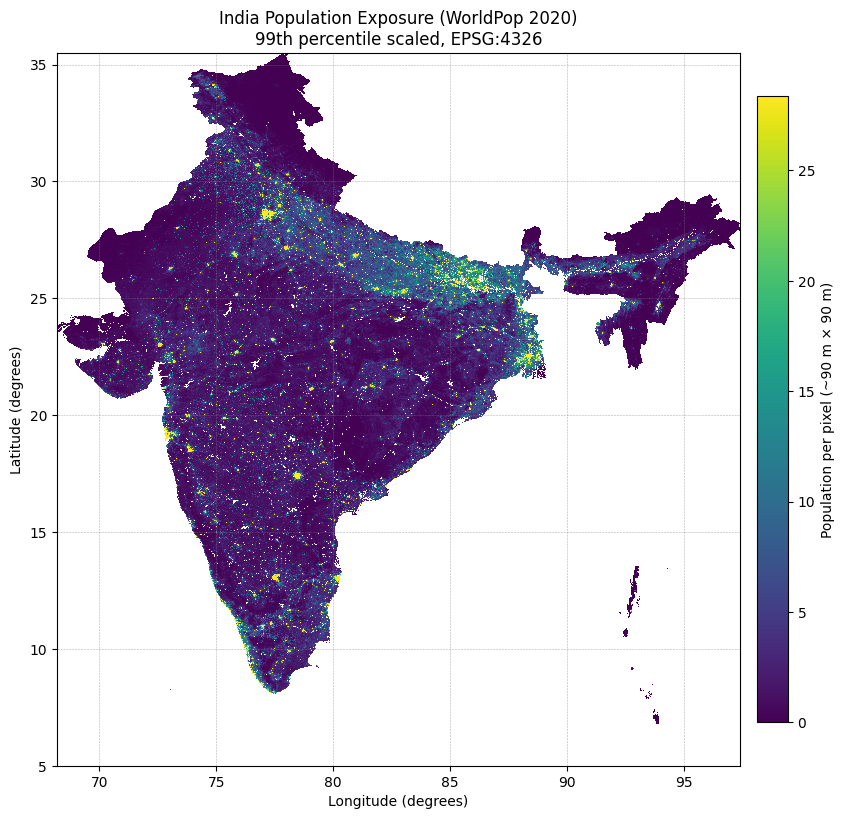

Exposure raster summary
-----------------------
Pixel count (valid): 393921894
99th percentile value: 28.363988876342773
Max value (true): 2355.0823


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load population data
# -----------------------------
pop = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/pop/ind_ppp_2020_UNadj.npy"
)

# Mask invalid / nodata values explicitly
pop = np.where(pop < 0, np.nan, pop)

# -----------------------------
# Geographic extent (EPSG:4326)
# -----------------------------
extent = [
    68.185416408,   # lon_min
    97.414582958,   # lon_max
    6.753750174,    # lat_min
    35.501250059    # lat_max
]

# -----------------------------
# Robust scaling for exposure
# -----------------------------
vmax = np.nanpercentile(pop, 99)

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 9))

img = ax.imshow(
    pop,
    extent=extent,
    origin="upper",          # GeoTIFF convention
    cmap="viridis",
    vmin=0,
    vmax=vmax,
    interpolation="nearest"
)

# Colorbar (compact, readable)
cbar = fig.colorbar(
    img,
    ax=ax,
    shrink=0.72,
    pad=0.02
)
cbar.set_label("Population per pixel (~90 m × 90 m)")

# Axes & grid
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Latitude (degrees)")
ax.set_title(
    "India Population Exposure (WorldPop 2020)\n"
    "99th percentile scaled, EPSG:4326"
)

ax.set_xticks(np.arange(70, 100, 5))
ax.set_yticks(np.arange(5, 40, 5))
ax.grid(
    color="gray",
    linestyle="--",
    linewidth=0.4,
    alpha=0.6
)

plt.tight_layout()
plt.show()

print("Exposure raster summary")
print("-----------------------")
print("Pixel count (valid):", np.isfinite(pop).sum())
print("99th percentile value:", vmax)
print("Max value (true):", np.nanmax(pop))


Using basin zoom extent: [78.32666666666668, 78.9316666666667, 17.211221635606584, 17.606012318929068]


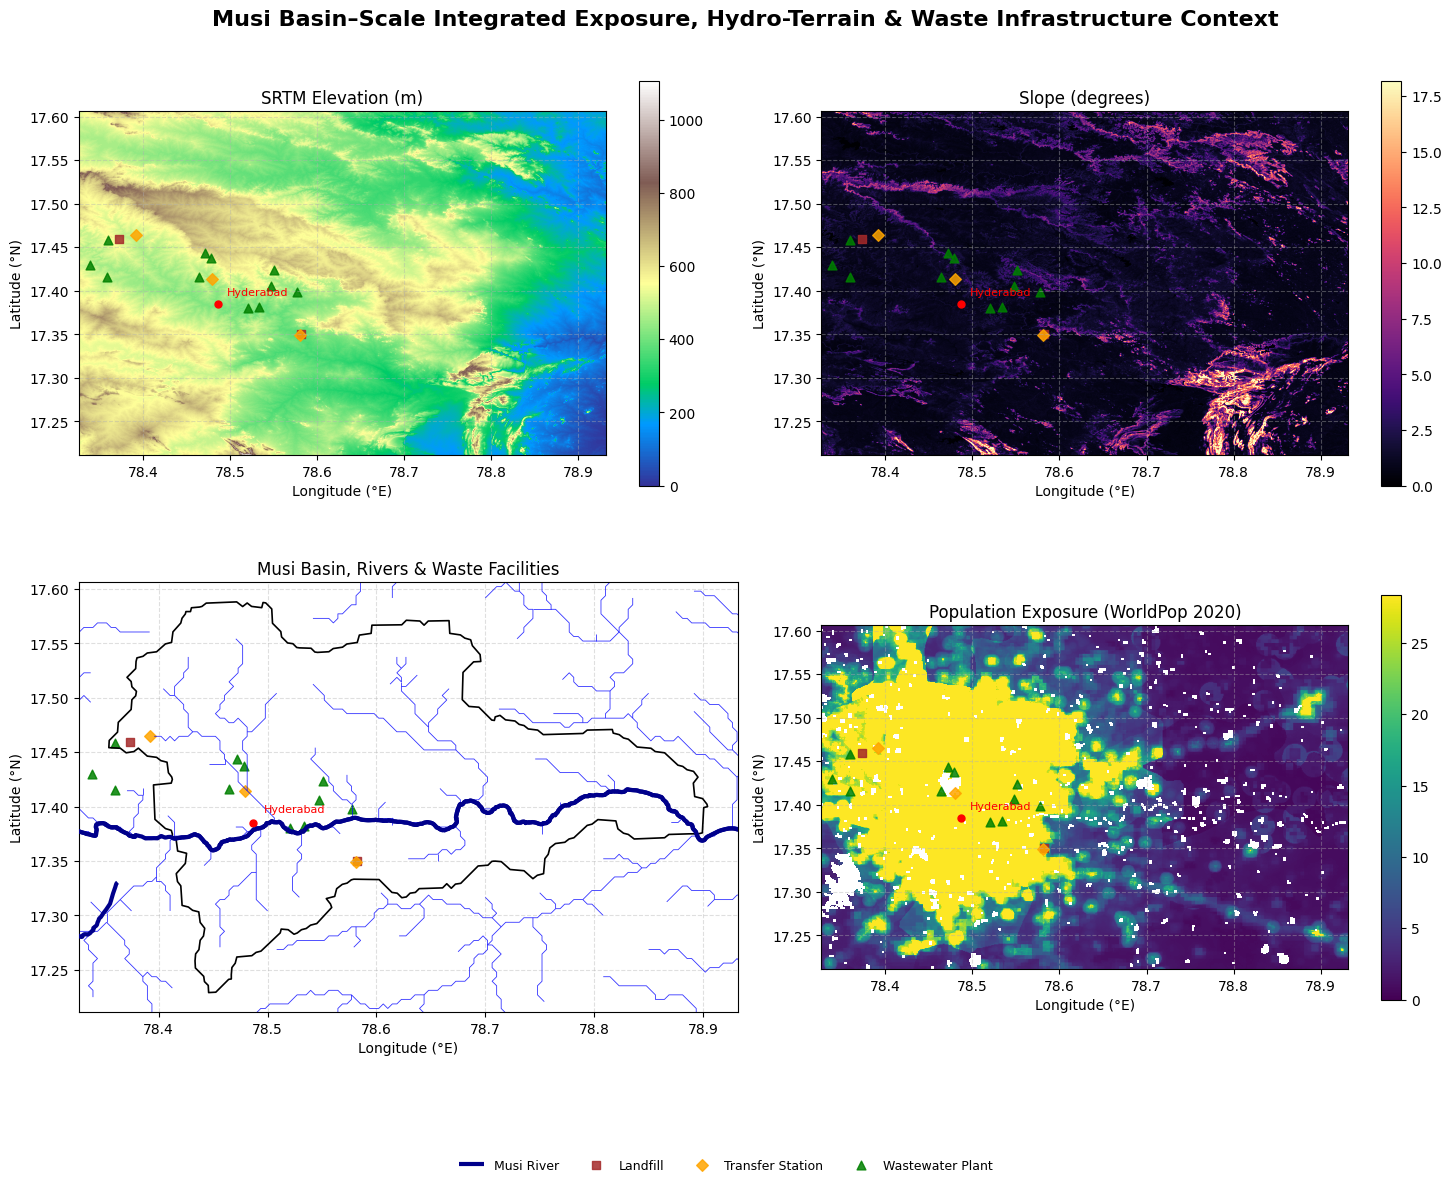

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# ============================================================
# LOAD DATA
# ============================================================

# Raster data
dem = np.load("/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/dem_hyderabad.npy")
slope = np.load("/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/slope_deg_corrected.npy")

pop = np.load("/vol/sandeep_storage/Files2/catastrophe/pop/ind_ppp_2020_UNadj.npy")
pop = np.where(pop < 0, np.nan, pop)

# Vector data
basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/hydrorivers_clean.geojson"
).to_crs(epsg=4326)


musi_named = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/musi.geojson"
).to_crs(epsg=4326)

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_clean.geojson"
).to_crs(epsg=4326)

# ============================================================
# HYDERABAD LOCATION
# ============================================================

hyd_lon, hyd_lat = 78.4867, 17.3850

# ============================================================
# BASIN-BASED EXTENT (AUTO ZOOM)
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds

pad_x = 0.05 * (maxx - minx)
pad_y = 0.05 * (maxy - miny)

extent = [
    minx - pad_x,
    maxx + pad_x,
    miny - pad_y,
    maxy + pad_y
]

print("Using basin zoom extent:", extent)

# ============================================================
# ROBUST SCALING
# ============================================================

pop_vmax = np.nanpercentile(pop, 99)
slope_vmax = np.nanpercentile(slope, 99)

# ============================================================
# WASTE FACILITY STYLES
# ============================================================

facility_style = {
    "landfill": dict(marker="s", color="brown", s=40),
    "recycling": dict(marker="o", color="blue", s=35),
    "transfer_station": dict(marker="D", color="orange", s=35),
    "wastewater_plant": dict(marker="^", color="green", s=40),
    "other": dict(marker="x", color="black", s=30),
}

def plot_waste(ax, gdf):
    for ftype, style in facility_style.items():
        subset = gdf[gdf["facility_type"] == ftype]
        if len(subset) > 0:
            ax.scatter(
                subset.geometry.x,
                subset.geometry.y,
                label=ftype.replace("_", " ").title(),
                alpha=0.85,
                **style
            )

# ============================================================
# FIGURE
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 13))
(ax1, ax2), (ax3, ax4) = axes

# ------------------------------------------------------------
# 1. DEM
# ------------------------------------------------------------
im1 = ax1.imshow(
    dem,
    extent=extent,
    origin="upper",
    cmap="terrain"
)
plot_waste(ax1, waste)
ax1.plot(hyd_lon, hyd_lat, "ro", markersize=5)
ax1.text(hyd_lon + 0.01, hyd_lat + 0.01, "Hyderabad", color="red", fontsize=8)
ax1.set_title("SRTM Elevation (m)")
plt.colorbar(im1, ax=ax1, shrink=0.7)

# ------------------------------------------------------------
# 2. Slope
# ------------------------------------------------------------
im2 = ax2.imshow(
    slope,
    extent=extent,
    origin="upper",
    cmap="magma",
    vmin=0,
    vmax=slope_vmax
)
plot_waste(ax2, waste)
ax2.plot(hyd_lon, hyd_lat, "ro", markersize=5)
ax2.text(hyd_lon + 0.01, hyd_lat + 0.01, "Hyderabad", color="red", fontsize=8)
ax2.set_title("Slope (degrees)")
plt.colorbar(im2, ax=ax2, shrink=0.7)

# ------------------------------------------------------------
# 3. HYDROGRAPHY (UPDATED: add Musi river here ONLY)
# ------------------------------------------------------------

# Basin boundary
basin.boundary.plot(
    ax=ax3,
    color="black",
    linewidth=1.2,
    
)

# HydroRIVERS network (context)
rivers.plot(
    ax=ax3,
    color="blue",
    linewidth=0.6,
    alpha=0.8
   
)

# Named Musi River (highlighted)
musi_named.plot(
    ax=ax3,
    color="darkblue",
    linewidth=3.0,
    label="Musi River",
    zorder=5
)

# Waste facilities
plot_waste(ax3, waste)

# Hyderabad marker
ax3.plot(hyd_lon, hyd_lat, "ro", markersize=5)
ax3.text(hyd_lon + 0.01, hyd_lat + 0.01, "Hyderabad", color="red", fontsize=8)

ax3.set_title("Musi Basin, Rivers & Waste Facilities")

# ------------------------------------------------------------
# 4. Population Exposure
# ------------------------------------------------------------
im4 = ax4.imshow(
    pop,
    extent=[68.185416408, 97.414582958, 6.753750174, 35.501250059],
    origin="upper",
    cmap="viridis",
    vmin=0,
    vmax=pop_vmax
)
ax4.set_xlim(extent[0], extent[1])
ax4.set_ylim(extent[2], extent[3])
plot_waste(ax4, waste)
ax4.plot(hyd_lon, hyd_lat, "ro", markersize=5)
ax4.text(hyd_lon + 0.01, hyd_lat + 0.01, "Hyderabad", color="red", fontsize=8)
ax4.set_title("Population Exposure (WorldPop 2020)")
plt.colorbar(im4, ax=ax4, shrink=0.7)

# ------------------------------------------------------------
# COMMON AXIS FORMATTING
# ------------------------------------------------------------
for ax in axes.flat:
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")
    ax.grid(True, linestyle="--", alpha=0.4)

# ------------------------------------------------------------
# SINGLE LEGEND (from hydrography panel)
# ------------------------------------------------------------
handles, labels = ax3.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,
    fontsize=9,
    frameon=False
)

plt.suptitle(
    "Musi Basin–Scale Integrated Exposure, Hydro-Terrain & Waste Infrastructure Context",
    fontsize=16,
    weight="bold",
    y=0.9
)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])
plt.show()


### era5 + musi basin

In [31]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# ------------------------------------------------------------
# PATHS
# ------------------------------------------------------------
era5_path = "/vol/sandeep_storage/Files2/catastrophe/era5_catastrophe_daily_full_2010_2024.parquet"
basin_path = "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"

out_era5 = "/vol/sandeep_storage/Files2/catastrophe/era5_musi.parquet"
out_grid = "/vol/sandeep_storage/Files2/catastrophe/era5_grid.npy"

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------
era5 = pd.read_parquet(era5_path)

basin = gpd.read_file(basin_path).to_crs(epsg=4326)

# ------------------------------------------------------------
# POINT-IN-POLYGON FILTER (VECTORISED)
# ------------------------------------------------------------
geometry = gpd.points_from_xy(
    era5["longitude"].values,
    era5["latitude"].values
)

era5_gdf = gpd.GeoDataFrame(
    era5,
    geometry=geometry,
    crs="EPSG:4326"
)

era5_musi = era5_gdf[era5_gdf.within(basin.geometry.iloc[0])]

# Drop geometry for efficiency
era5_musi = pd.DataFrame(era5_musi.drop(columns="geometry"))

# ------------------------------------------------------------
# SAVE FILTERED ERA5
# ------------------------------------------------------------
era5_musi.to_parquet(out_era5, index=False)

print("ERA5 filtered to Musi basin")
print("Rows:", len(era5_musi))
print("Date range:", era5_musi["valid_time"].min(), "→", era5_musi["valid_time"].max())

# ------------------------------------------------------------
# BUILD & SAVE MASTER GRID
# ------------------------------------------------------------
grid = (
    era5_musi[["latitude", "longitude"]]
    .drop_duplicates()
    .sort_values(["latitude", "longitude"])
    .values
)

np.save(out_grid, grid)

print("ERA5 master grid saved")
print("Grid points:", grid.shape[0])


ERA5 filtered to Musi basin
Rows: 5479
Date range: 2010-01-01 00:00:00 → 2024-12-31 00:00:00
ERA5 master grid saved
Grid points: 1


In [32]:
import pandas as pd
import geopandas as gpd
import numpy as np

# ------------------------------------------------------------
# PATHS
# ------------------------------------------------------------
era5_path = "/vol/sandeep_storage/Files2/catastrophe/era5_catastrophe_daily_full_2010_2024.parquet"
basin_path = "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"

out_era5 = "/vol/sandeep_storage/Files2/catastrophe/era5_musi_buffered.parquet"
out_grid = "/vol/sandeep_storage/Files2/catastrophe/era5_grid_buffered.npy"

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------
era5 = pd.read_parquet(era5_path)
basin = gpd.read_file(basin_path).to_crs(epsg=4326)

# ------------------------------------------------------------
# BUILD BUFFERED BBOX
# ------------------------------------------------------------
minx, miny, maxx, maxy = basin.total_bounds

buffer = 0.25  # one ERA5 grid
bbox = {
    "minx": minx - buffer,
    "maxx": maxx + buffer,
    "miny": miny - buffer,
    "maxy": maxy + buffer
}

print("Buffered bbox:", bbox)

# ------------------------------------------------------------
# FILTER ERA5 BY BBOX
# ------------------------------------------------------------
era5_buf = era5[
    (era5["longitude"] >= bbox["minx"]) &
    (era5["longitude"] <= bbox["maxx"]) &
    (era5["latitude"]  >= bbox["miny"]) &
    (era5["latitude"]  <= bbox["maxy"])
]

# ------------------------------------------------------------
# SAVE
# ------------------------------------------------------------
era5_buf.to_parquet(out_era5, index=False)

grid = (
    era5_buf[["latitude", "longitude"]]
    .drop_duplicates()
    .sort_values(["latitude", "longitude"])
    .values
)

np.save(out_grid, grid)

print("Buffered ERA5 extracted")
print("Rows:", len(era5_buf))
print("Grid points:", grid.shape[0])
print("Lat range:", grid[:,0].min(), "→", grid[:,0].max())
print("Lon range:", grid[:,1].min(), "→", grid[:,1].max())


Buffered bbox: {'minx': 78.10416666666669, 'maxx': 79.1541666666667, 'miny': 16.979166666666696, 'maxy': 17.838067287868956}
Buffered ERA5 extracted
Rows: 87664
Grid points: 16
Lat range: 17.0 → 17.75
Lon range: 78.25 → 79.0


Visualizing date: 2010-07-24


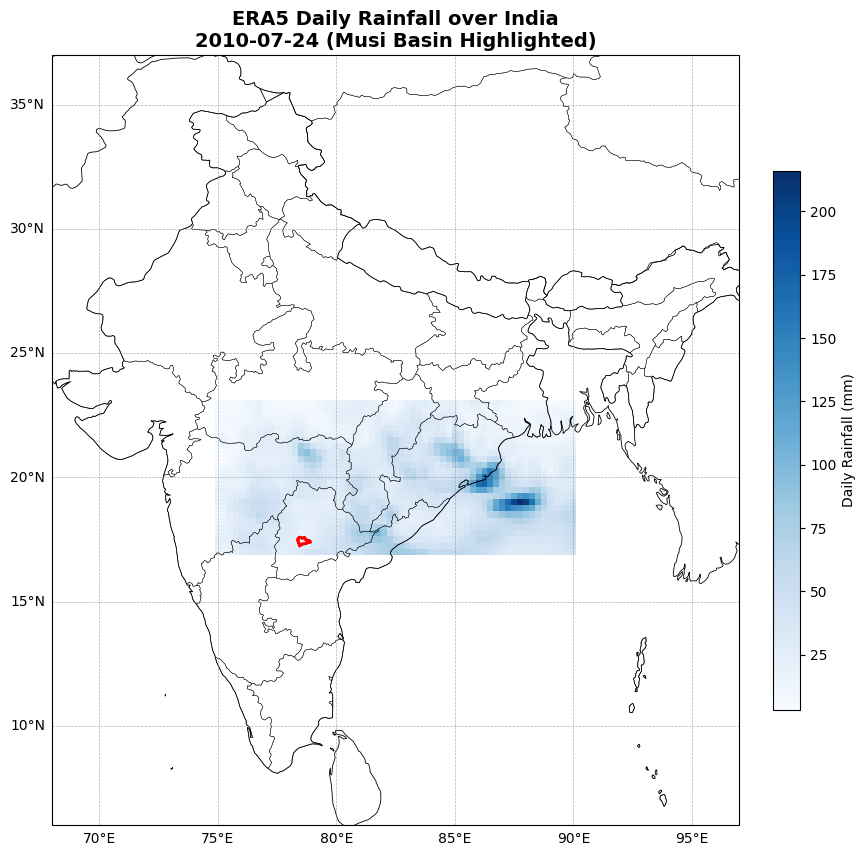

In [37]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ------------------------------------------------------------
# LOAD FULL ERA5 (ALL INDIA)
# ------------------------------------------------------------
era5 = pd.read_parquet(
    "/vol/sandeep_storage/Files2/catastrophe/era5_catastrophe_daily_full_2010_2024.parquet"
)

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
).to_crs(epsg=4326)

# ------------------------------------------------------------
# SELECT REPRESENTATIVE DAY (99th percentile over India)
# ------------------------------------------------------------
p99_day = (
    era5.groupby("valid_time")["tp_total_mm"]
    .mean()
    .sort_values()
    .index[-1]
)

snap = era5[era5["valid_time"] == p99_day]
print("Visualizing date:", p99_day.date())

# ------------------------------------------------------------
# BUILD INDIA-WIDE GRID
# ------------------------------------------------------------
lats = np.sort(snap["latitude"].unique())
lons = np.sort(snap["longitude"].unique())

rain = snap.pivot(
    index="latitude",
    columns="longitude",
    values="tp_total_mm"
).values

Lon, Lat = np.meshgrid(lons, lats)

# ------------------------------------------------------------
# CARTOPY MAP
# ------------------------------------------------------------
fig = plt.figure(figsize=(11, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# India extent
ax.set_extent([68, 97, 6, 37], crs=ccrs.PlateCarree())

# ERA5 rainfall
pcm = ax.pcolormesh(
    Lon,
    Lat,
    rain,
    cmap="Blues",
    shading="nearest",
    transform=ccrs.PlateCarree()
)

# Musi basin boundary
basin.boundary.plot(
    ax=ax,
    edgecolor="red",
    linewidth=2,
    transform=ccrs.PlateCarree(),
    label="Musi Basin"
)

# ------------------------------------------------------------
# MAP FEATURES
# ------------------------------------------------------------
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES, linewidth=0.3)

# ------------------------------------------------------------
# LAT–LON GRIDLINES (THIS IS WHAT YOU ASKED FOR)
# ------------------------------------------------------------
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color="gray",
    alpha=0.6,
    linestyle="--"
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

# ------------------------------------------------------------
# COLORBAR & TITLE
# ------------------------------------------------------------
cb = plt.colorbar(pcm, ax=ax, shrink=0.7, pad=0.04)
cb.set_label("Daily Rainfall (mm)")

ax.set_title(
    f"ERA5 Daily Rainfall over India\n{p99_day.date()} (Musi Basin Highlighted)",
    fontsize=14,
    weight="bold"
)

plt.show()


Wettest day in Musi region: 2024-09-01


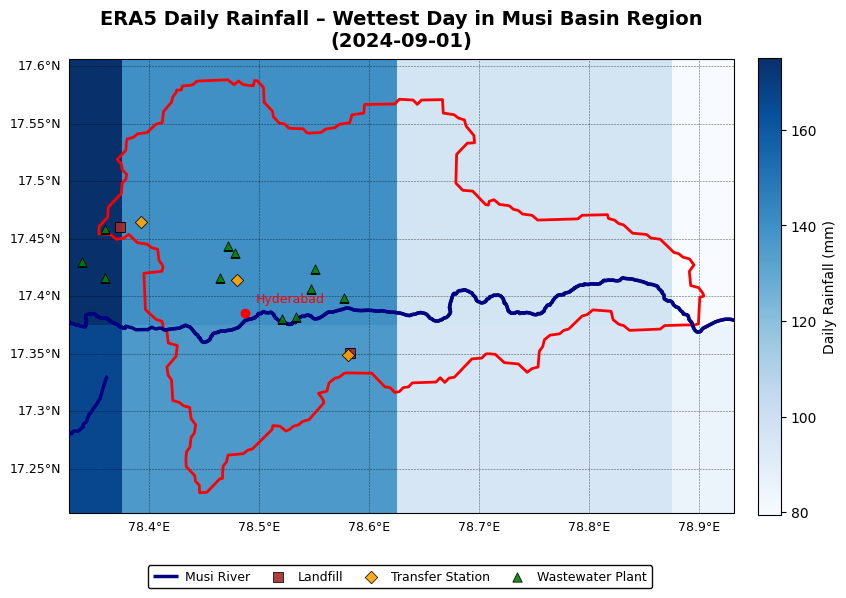

In [82]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ============================================================
# LOAD ERA5 MUSI-BUFFERED DATA
# ============================================================

era5_musi = pd.read_parquet(
    "/vol/sandeep_storage/Files2/catastrophe/era5_musi_buffered.parquet"
)

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
).to_crs(epsg=4326)

musi_river = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/musi.geojson"
).to_crs(epsg=4326)

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_clean.geojson"
).to_crs(epsg=4326)

# ============================================================
# HYDERABAD LOCATION
# ============================================================

hyd_lon, hyd_lat = 78.4867, 17.3850

# ============================================================
# SELECT WETTEST DAY OVER MUSI REGION (SPATIAL MEAN)
# ============================================================

wettest_day = (
    era5_musi.groupby("valid_time")["tp_total_mm"]
    .mean()
    .sort_values()
    .index[-1]
)

snap = era5_musi[era5_musi["valid_time"] == wettest_day]

print("Wettest day in Musi region:", wettest_day.date())

# ============================================================
# BUILD 2D ERA5 GRID
# ============================================================

lats = np.sort(snap["latitude"].unique())
lons = np.sort(snap["longitude"].unique())

rain = snap.pivot(
    index="latitude",
    columns="longitude",
    values="tp_total_mm"
).values

Lon, Lat = np.meshgrid(lons, lats)

# ============================================================
# MUSI-BASED EXTENT (SAME LOGIC AS CONTEXT FIGURE)
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds
pad_x = 0.05 * (maxx - minx)
pad_y = 0.05 * (maxy - miny)

extent = [
    minx - pad_x,
    maxx + pad_x,
    miny - pad_y,
    maxy + pad_y
]

# ============================================================
# WASTE FACILITY STYLES (CONSISTENT)
# ============================================================

facility_style = {
    "landfill": dict(marker="s", color="brown", s=45, edgecolor="black", linewidth=0.6),
    "recycling": dict(marker="o", color="blue", s=40, edgecolor="black", linewidth=0.6),
    "transfer_station": dict(marker="D", color="orange", s=40, edgecolor="black", linewidth=0.6),
    "wastewater_plant": dict(marker="^", color="green", s=45, edgecolor="black", linewidth=0.6),
    "other": dict(marker="x", color="black", s=35, edgecolor="black", linewidth=0.6),
}


def plot_waste(ax, gdf):
    for ftype, style in facility_style.items():
        subset = gdf[gdf["facility_type"] == ftype]
        if len(subset) > 0:
            ax.scatter(
                subset.geometry.x,
                subset.geometry.y,
                label=ftype.replace("_", " ").title(),
                alpha=0.9,
                transform=ccrs.PlateCarree(),
                zorder=5,
                **style
            )

# ============================================================
# CARTOPY MAP
# ============================================================

fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# ERA5 rainfall
pcm = ax.pcolormesh(
    Lon,
    Lat,
    rain,
    cmap="Blues",
    shading="nearest",
    transform=ccrs.PlateCarree(),
    zorder=1
)

# Basin boundary
basin.boundary.plot(
    ax=ax,
    edgecolor="red",
    linewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=3
)

# Musi river
musi_river.plot(
    ax=ax,
    color="navy",
    linewidth=2.5,
    transform=ccrs.PlateCarree(),
    zorder=4,
    label="Musi River"
)

# Waste facilities
plot_waste(ax, waste)

# Hyderabad marker
ax.plot(
    hyd_lon, hyd_lat,
    "ro",
    markersize=6,
    transform=ccrs.PlateCarree(),
    zorder=6
)
ax.text(
    hyd_lon + 0.01, hyd_lat + 0.01,
    "Hyderabad",
    color="red",
    fontsize=9,
    transform=ccrs.PlateCarree()
)

# Map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.STATES, linewidth=0.3)

# Gridlines
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.4,
    color="black",
    alpha=0.6,
    linestyle="--"
)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 9}
gl.ylabel_style = {"size": 9}

# Colorbar

cb = plt.colorbar(
    pcm,
    ax=ax,
    shrink=0.6,     
    pad=0.03
)
cb.set_label("Daily Rainfall (mm)", fontsize=10)

handles, labels = ax.get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=len(labels),          
    fontsize=9,
    frameon=True,
    fancybox=True,
    framealpha=0.95,
    edgecolor="black",
    handlelength=2.0,
    handletextpad=0.6,
    columnspacing=1.2,
    borderpad=0.4,            
    bbox_to_anchor=(0.45, 0.12)
)




ax.set_title(
    f"ERA5 Daily Rainfall – Wettest Day in Musi Basin Region\n({wettest_day.date()})",
    fontsize=14,
    weight="bold",
    y=1.01
)
plt.tight_layout(rect=[0, 0.01, 1, 1])

plt.show()


### Vulnerability

#### drainage 

In [6]:
import geopandas as gpd
import numpy as np

# ============================================================
# LOAD DATA (YOUR EXACT FILE PATHS)
# ============================================================

# Waste facilities
waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_clean.geojson"
).to_crs(epsg=4326)

# Full HydroRIVERS network (cleaned)
rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/hydrorivers_clean.geojson"
).to_crs(epsg=4326)

# ============================================================
# PROJECT TO METRIC CRS (CRITICAL FOR DISTANCE)
# UTM Zone 44N covers Hyderabad
# ============================================================

waste_m = waste.to_crs(epsg=32644)
rivers_m = rivers.to_crs(epsg=32644)

# ============================================================
# BUILD SINGLE GEOMETRY FOR FAST DISTANCE COMPUTATION
# (UPDATED: no deprecation warning)
# ============================================================

river_geom = rivers_m.geometry.union_all()

# ============================================================
# COMPUTE DISTANCE TO NEAREST DRAINAGE CHANNEL (METERS)
# ============================================================

waste_m["dist_to_drainage_m"] = waste_m.geometry.distance(river_geom)

print("Distance to drainage (meters):")
print(waste_m["dist_to_drainage_m"].describe())

# ============================================================
# CONVERT DISTANCE → VULNERABILITY SCORE
# Logic: closer to drainage = higher flood vulnerability
# ============================================================

MAX_DIST = 5000.0  # meters (physically justified)

dist_clipped = np.clip(waste_m["dist_to_drainage_m"], 0, MAX_DIST)

waste_m["vuln_drainage"] = 1.0 - (dist_clipped / MAX_DIST)
waste_m["vuln_drainage"] = waste_m["vuln_drainage"].clip(0, 1)

print("\nDrainage vulnerability score stats:")
print(waste_m["vuln_drainage"].describe())

# ============================================================
# SAVE OUTPUT (GEOMETRY + CRS SAFE)
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_with_drainage_vulnerability.geojson"
)

waste_out = waste_m.to_crs(epsg=4326)
waste_out = waste_out.set_geometry("geometry")
waste_out = waste_out.set_crs(epsg=4326, allow_override=True)

waste_out.to_file(out_path, driver="GeoJSON")

print("\nSaved correctly:", out_path)


Distance to drainage (meters):
count      16.000000
mean     1443.899670
std      1394.040073
min        28.441820
25%       269.932061
50%      1024.904848
75%      2642.056830
max      3927.273430
Name: dist_to_drainage_m, dtype: float64

Drainage vulnerability score stats:
count    16.000000
mean      0.711220
std       0.278808
min       0.214545
25%       0.471589
50%       0.795019
75%       0.946014
max       0.994312
Name: vuln_drainage, dtype: float64

Saved correctly: /vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_with_drainage_vulnerability.geojson


In [7]:
waste_out.sort_values("dist_to_drainage_m").head()


,facility_type,geometry,dist_to_drainage_m,vuln_drainage
3,wastewater_plant,POINT (78.57735 17.39818),28.441820,0.994312
15,wastewater_plant,POINT (78.52038 17.38051),68.165946,0.986367
1,wastewater_plant,POINT (78.53388 17.3818),159.951078,0.968010
4,transfer_station,POINT (78.47969 17.41394),168.646433,0.966271
6,wastewater_plant,POINT (78.47839 17.43744),303.693938,0.939261


In [8]:
waste_out.sort_values("dist_to_drainage_m")


,facility_type,geometry,dist_to_drainage_m,vuln_drainage
3,wastewater_plant,POINT (78.57735 17.39818),28.441820,0.994312
15,wastewater_plant,POINT (78.52038 17.38051),68.165946,0.986367
1,wastewater_plant,POINT (78.53388 17.3818),159.951078,0.968010
4,transfer_station,POINT (78.47969 17.41394),168.646433,0.966271
6,wastewater_plant,POINT (78.47839 17.43744),303.693938,0.939261
10,transfer_station,POINT (78.3921 17.46459),396.378695,0.920724
8,wastewater_plant,POINT (78.5509 17.42333),568.492664,0.886301
5,wastewater_plant,POINT (78.47197 17.44359),873.892710,0.825221
0,wastewater_plant,POINT (78.46435 17.41619),1175.916986,0.764817
7,wastewater_plant,POINT (78.35948 17.41553),1211.262999,0.757747


#### elevation

In [12]:
import numpy as np
import geopandas as gpd

# ============================================================
# LOAD DATA (EXACT FILE PATHS)
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_with_drainage_vulnerability.geojson"
).to_crs(epsg=4326)

dem = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/dem_hyderabad.npy"
)

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
).to_crs(epsg=4326)

# ============================================================
# DEM GRID METADATA
# ============================================================

dx = dy = 0.0008333333333333334  # ~90 m SRTM
minx, miny, maxx, maxy = basin.total_bounds
nrows, ncols = dem.shape

# ============================================================
# SAMPLE DEM AT FACILITY LOCATIONS
# ============================================================

facility_elev = []

for geom in waste.geometry:
    x, y = geom.x, geom.y

    col = int((x - minx) / dx)
    row = int((maxy - y) / dy)

    if 0 <= row < nrows and 0 <= col < ncols:
        facility_elev.append(dem[row, col])
    else:
        facility_elev.append(np.nan)

waste["elevation_m"] = facility_elev

print("Facility elevation stats (raw, before imputation):")
print(waste["elevation_m"].describe())

# ============================================================
# MEDIAN IMPUTATION (EDGE-CASE SAFE)
# ============================================================

median_elev = waste["elevation_m"].median()
waste["elevation_m"] = waste["elevation_m"].fillna(median_elev)

print("\nMedian elevation used for imputation:", median_elev)

# ============================================================
# ELEVATION-BASED VULNERABILITY (AFTER IMPUTATION)
# ============================================================

waste["elev_percentile"] = waste["elevation_m"].rank(pct=True)
waste["vuln_elevation"] = (1.0 - waste["elev_percentile"]).clip(0, 1)

print("\nElevation vulnerability stats (final):")
print(waste["vuln_elevation"].describe())

# ============================================================
# SAVE OUTPUT (GEOMETRY + CRS SAFE)
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_with_drainage_and_elevation_vulnerability.geojson"
)

waste = waste.set_geometry("geometry")
waste = waste.set_crs(epsg=4326, allow_override=True)

waste.to_file(out_path, driver="GeoJSON")

print("\nSaved correctly:", out_path)


Facility elevation stats (raw, before imputation):
count     15.000000
mean     513.266667
std       12.423863
min      493.000000
25%      503.500000
50%      515.000000
75%      523.000000
max      532.000000
Name: elevation_m, dtype: float64

Median elevation used for imputation: 515.0

Elevation vulnerability stats (final):
count    16.000000
mean      0.468750
std       0.296464
min       0.000000
25%       0.234375
50%       0.500000
75%       0.703125
max       0.937500
Name: vuln_elevation, dtype: float64

Saved correctly: /vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_with_drainage_and_elevation_vulnerability.geojson


In [13]:
waste


,facility_type,dist_to_drainage_m,vuln_drainage,geometry,elevation_m,elev_percentile,vuln_elevation
0,wastewater_plant,1175.916986,0.764817,POINT (78.46435 17.41619),515.0,0.50000,0.50000
1,wastewater_plant,159.951078,0.968010,POINT (78.53388 17.3818),502.0,0.25000,0.75000
2,landfill,3187.375573,0.362525,POINT (78.5822 17.35038),495.0,0.12500,0.87500
3,wastewater_plant,28.441820,0.994312,POINT (78.57735 17.39818),518.0,0.65625,0.34375
4,transfer_station,168.646433,0.966271,POINT (78.47969 17.41394),528.0,0.93750,0.06250
5,wastewater_plant,873.892710,0.825221,POINT (78.47197 17.44359),532.0,1.00000,0.00000
6,wastewater_plant,303.693938,0.939261,POINT (78.47839 17.43744),526.0,0.87500,0.12500
7,wastewater_plant,1211.262999,0.757747,POINT (78.35948 17.41553),493.0,0.06250,0.93750
8,wastewater_plant,568.492664,0.886301,POINT (78.5509 17.42333),525.0,0.81250,0.18750
9,landfill,2460.283916,0.507943,POINT (78.37324 17.45976),515.0,0.50000,0.50000


#### slope

In [16]:
import numpy as np

# ============================================================
# LOAD DEM
# ============================================================

dem = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/dem_hyderabad.npy"
)

# ============================================================
# GRID SPACING IN METERS (HYDERABAD ~17.4°N)
# ============================================================

deg = 0.0008333333333333334  # SRTM grid spacing (degrees)

dy_m = 111_000 * deg        # latitude meters
dx_m = 106_000 * deg        # longitude meters (cos(lat) adjusted)

# ============================================================
# COMPUTE GRADIENTS (METERS / METER)
# ============================================================

dz_dy, dz_dx = np.gradient(dem, dy_m, dx_m)

# ============================================================
# SLOPE (DEGREES)
# ============================================================

slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
slope_deg = np.degrees(slope_rad)

print("Corrected slope stats (degrees):")
print(
    "Min:", np.nanmin(slope_deg),
    "Median:", np.nanmedian(slope_deg),
    "Max:", np.nanmax(slope_deg)
)

# ============================================================
# SAVE CORRECTED SLOPE
# ============================================================

np.save(
    "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/"
    "slope_deg_corrected.npy",
    slope_deg
)

print("Saved corrected slope raster.")


Corrected slope stats (degrees):
Min: 0.0 Median: 1.1329843093396221 Max: 57.32720966079008
Saved corrected slope raster.


In [17]:
import numpy as np
import geopandas as gpd

# ============================================================
# LOAD DATA
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_with_drainage_and_elevation_vulnerability.geojson"
).to_crs(epsg=4326)

slope = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/srtm_hyderabad/"
    "slope_deg_corrected.npy"
)

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/musi_basin.shp"
).to_crs(epsg=4326)

# ============================================================
# GRID METADATA
# ============================================================

dx = dy = 0.0008333333333333334
minx, miny, maxx, maxy = basin.total_bounds
nrows, ncols = slope.shape

# ============================================================
# SAMPLE SLOPE AT FACILITIES
# ============================================================

facility_slope = []

for geom in waste.geometry:
    x, y = geom.x, geom.y
    col = int((x - minx) / dx)
    row = int((maxy - y) / dy)

    if 0 <= row < nrows and 0 <= col < ncols:
        facility_slope.append(slope[row, col])
    else:
        facility_slope.append(np.nan)

waste["slope_deg"] = facility_slope

print("Facility slope stats (raw):")
print(waste["slope_deg"].describe())

# ============================================================
# MEDIAN IMPUTATION (EDGE SAFE)
# ============================================================

median_slope = waste["slope_deg"].median()
waste["slope_deg"] = waste["slope_deg"].fillna(median_slope)

print("\nMedian slope used:", median_slope)

# ============================================================
# SLOPE VULNERABILITY
# Low slope → high vulnerability
# ============================================================

waste["slope_percentile"] = waste["slope_deg"].rank(pct=True)
waste["vuln_slope"] = (1.0 - waste["slope_percentile"]).clip(0, 1)

print("\nSlope vulnerability stats:")
print(waste["vuln_slope"].describe())

# ============================================================
# SAVE FINAL DATASET
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_with_drainage_elevation_slope_vulnerability.geojson"
)

waste = waste.set_geometry("geometry")
waste = waste.set_crs(epsg=4326, allow_override=True)
waste.to_file(out_path, driver="GeoJSON")

print("\nSaved correctly:", out_path)


Facility slope stats (raw):
count    15.000000
mean      0.740953
std       0.384671
min       0.000000
25%       0.633997
50%       0.699146
75%       0.978427
max       1.280363
Name: slope_deg, dtype: float64

Median slope used: 0.6991463830479475

Slope vulnerability stats:
count    16.000000
mean      0.468750
std       0.294922
min       0.000000
25%       0.257812
50%       0.531250
75%       0.703125
max       0.906250
Name: vuln_slope, dtype: float64

Saved correctly: /vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_with_drainage_elevation_slope_vulnerability.geojson


In [19]:
waste


,facility_type,dist_to_drainage_m,vuln_drainage,elevation_m,elev_percentile,vuln_elevation,geometry,slope_deg,slope_percentile,vuln_slope
0,wastewater_plant,1175.916986,0.764817,515.0,0.50000,0.50000,POINT (78.46435 17.41619),1.238635,0.93750,0.06250
1,wastewater_plant,159.951078,0.968010,502.0,0.25000,0.75000,POINT (78.53388 17.3818),0.699146,0.46875,0.53125
2,landfill,3187.375573,0.362525,495.0,0.12500,0.87500,POINT (78.5822 17.35038),0.972854,0.71875,0.28125
3,wastewater_plant,28.441820,0.994312,518.0,0.65625,0.34375,POINT (78.57735 17.39818),0.718740,0.62500,0.37500
4,transfer_station,168.646433,0.966271,528.0,0.93750,0.06250,POINT (78.47969 17.41394),0.448432,0.18750,0.81250
5,wastewater_plant,873.892710,0.825221,532.0,1.00000,0.00000,POINT (78.47197 17.44359),0.000000,0.09375,0.90625
6,wastewater_plant,303.693938,0.939261,526.0,0.87500,0.12500,POINT (78.47839 17.43744),0.984000,0.81250,0.18750
7,wastewater_plant,1211.262999,0.757747,493.0,0.06250,0.93750,POINT (78.35948 17.41553),0.972854,0.71875,0.28125
8,wastewater_plant,568.492664,0.886301,525.0,0.81250,0.18750,POINT (78.5509 17.42333),1.280363,1.00000,0.00000
9,landfill,2460.283916,0.507943,515.0,0.50000,0.50000,POINT (78.37324 17.45976),0.619390,0.25000,0.75000


#### composite  flood hazard index 

In [86]:
import geopandas as gpd
import numpy as np
import pandas as pd

# ============================================================
# LOAD FINAL VULNERABILITY DATA
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_with_drainage_elevation_slope_vulnerability.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(waste))

# ============================================================
# COMPOSITE FLOOD HAZARD INDEX (STATIC)
# ============================================================

W_DRAIN = 0.45   # drainage / river proximity
W_ELEV  = 0.35   # floodplain / elevation control
W_SLOPE = 0.20   # runoff & local accumulation

waste["flood_hazard_index"] = (
    W_DRAIN * waste["vuln_drainage"] +
    W_ELEV  * waste["vuln_elevation"] +
    W_SLOPE * waste["vuln_slope"]
)

# Safety clip
waste["flood_hazard_index"] = waste["flood_hazard_index"].clip(0, 1)

print("\nFlood hazard index stats:")
print(waste["flood_hazard_index"].describe())

# ============================================================
# HAZARD CATEGORIES (PHYSICAL SUSCEPTIBILITY)
# ============================================================

bins = [0.0, 0.3, 0.6, 1.0]
labels = ["Low", "Moderate", "High"]

waste["hazard_category"] = pd.cut(
    waste["flood_hazard_index"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

print("\nHazard category counts:")
print(waste["hazard_category"].value_counts())

# ============================================================
# CLEANUP (REMOVE MISLEADING OLD NAME IF PRESENT)
# ============================================================

waste = waste.drop(columns=["flood_risk_score"], errors="ignore")

# ============================================================
# SAVE FINAL HAZARD LAYER
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_index.geojson"
)

waste = waste.set_geometry("geometry")
waste = waste.set_crs(epsg=4326, allow_override=True)

waste.to_file(out_path, driver="GeoJSON")

print("\nSaved FINAL flood hazard index layer:", out_path)


Loaded facilities: 16

Flood hazard index stats:
count    16.000000
mean      0.577862
std       0.132732
min       0.340295
25%       0.519623
50%       0.550045
75%       0.652834
max       0.821990
Name: flood_hazard_index, dtype: float64

Hazard category counts:
hazard_category
Moderate    10
High         6
Low          0
Name: count, dtype: int64

Saved FINAL flood hazard index layer: /vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_flood_hazard_index.geojson


In [88]:
waste


,facility_type,dist_to_drainage_m,vuln_drainage,elevation_m,elev_percentile,vuln_elevation,slope_deg,slope_percentile,vuln_slope,geometry,flood_hazard_index,hazard_category
0,wastewater_plant,1175.916986,0.764817,515.0,0.50000,0.50000,1.238635,0.93750,0.06250,POINT (78.46435 17.41619),0.531667,Moderate
1,wastewater_plant,159.951078,0.968010,502.0,0.25000,0.75000,0.699146,0.46875,0.53125,POINT (78.53388 17.3818),0.804354,High
2,landfill,3187.375573,0.362525,495.0,0.12500,0.87500,0.972854,0.71875,0.28125,POINT (78.5822 17.35038),0.525636,Moderate
3,wastewater_plant,28.441820,0.994312,518.0,0.65625,0.34375,0.718740,0.62500,0.37500,POINT (78.57735 17.39818),0.642753,High
4,transfer_station,168.646433,0.966271,528.0,0.93750,0.06250,0.448432,0.18750,0.81250,POINT (78.47969 17.41394),0.619197,High
5,wastewater_plant,873.892710,0.825221,532.0,1.00000,0.00000,0.000000,0.09375,0.90625,POINT (78.47197 17.44359),0.552600,Moderate
6,wastewater_plant,303.693938,0.939261,526.0,0.87500,0.12500,0.984000,0.81250,0.18750,POINT (78.47839 17.43744),0.503918,Moderate
7,wastewater_plant,1211.262999,0.757747,493.0,0.06250,0.93750,0.972854,0.71875,0.28125,POINT (78.35948 17.41553),0.725361,High
8,wastewater_plant,568.492664,0.886301,525.0,0.81250,0.18750,1.280363,1.00000,0.00000,POINT (78.5509 17.42333),0.464461,Moderate
9,landfill,2460.283916,0.507943,515.0,0.50000,0.50000,0.619390,0.25000,0.75000,POINT (78.37324 17.45976),0.553574,Moderate


### Facility-Level Population Exposure 

In [75]:
import numpy as np
import geopandas as gpd

# ============================================================
# LOAD FLOOD HAZARD FILE (AUTHORITATIVE)
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_index.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(waste))

# ============================================================
# LOAD WORLDPOP DATA
# ============================================================

pop = np.load(
    "/vol/sandeep_storage/Files2/catastrophe/pop/"
    "ind_ppp_2020_UNadj.npy"
)

# ============================================================
# WORLDPOP GRID METADATA (FROM TIFF)
# ============================================================

dx = dy = 0.0008333333333333334   # ~90 m
minx = 68.185416408               # left bound
maxy = 35.501250059               # top bound

nrows, ncols = pop.shape

# ============================================================
# SAMPLE POPULATION AT FACILITY LOCATIONS
# ============================================================

facility_pop = []

for geom in waste.geometry:
    lon, lat = geom.x, geom.y

    col = int((lon - minx) / dx)
    row = int((maxy - lat) / dy)

    if 0 <= row < nrows and 0 <= col < ncols:
        val = pop[row, col]
        facility_pop.append(val if not np.isnan(val) else np.nan)
    else:
        facility_pop.append(np.nan)

waste["population_density"] = facility_pop

print("\nPopulation density at facilities:")
print(waste["population_density"].describe())

# ============================================================
# HANDLE EDGE NaNs (ROBUST, NON-BIASED)
# ============================================================

median_pop = waste["population_density"].median()
waste["population_density"] = waste["population_density"].fillna(median_pop)

# ============================================================
# NORMALIZE → POPULATION EXPOSURE (SEPARATE FROM HAZARD)
# ============================================================

p99 = waste["population_density"].quantile(0.99)

waste["pop_exposure"] = (
    waste["population_density"] / p99
).clip(0, 1)

print("\nPopulation exposure score stats:")
print(waste["pop_exposure"].describe())

# ============================================================
# SAVE UPDATED HAZARD + EXPOSURE FILE
# ============================================================

out_path = (
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_with_population.geojson"
)

waste.to_file(out_path, driver="GeoJSON")

print("\nSaved correctly:", out_path)


Loaded facilities: 16

Population density at facilities:
count     14.000000
mean      60.076956
std       35.963419
min       21.405458
25%       31.236187
50%       52.445015
75%       73.976515
max      137.080780
Name: population_density, dtype: float64

Population exposure score stats:
count    16.000000
mean      0.436926
std       0.246370
min       0.158534
25%       0.236155
50%       0.388421
75%       0.547773
max       1.000000
Name: pop_exposure, dtype: float64

Saved correctly: /vol/sandeep_storage/Files2/catastrophe/osm/waste_facilities_flood_hazard_with_population.geojson


In [76]:
waste


,facility_type,dist_to_drainage_m,vuln_drainage,elevation_m,elev_percentile,vuln_elevation,slope_deg,slope_percentile,vuln_slope,flood_hazard_index,hazard_category,geometry,population_density,pop_exposure
0,wastewater_plant,1175.916986,0.764817,515.0,0.50000,0.50000,1.238635,0.93750,0.06250,0.531667,Moderate,POINT (78.46435 17.41619),52.445015,0.388421
1,wastewater_plant,159.951078,0.968010,502.0,0.25000,0.75000,0.699146,0.46875,0.53125,0.804354,High,POINT (78.53388 17.3818),73.984283,0.547946
2,landfill,3187.375573,0.362525,495.0,0.12500,0.87500,0.972854,0.71875,0.28125,0.525636,Moderate,POINT (78.5822 17.35038),30.298679,0.224399
3,wastewater_plant,28.441820,0.994312,518.0,0.65625,0.34375,0.718740,0.62500,0.37500,0.642753,High,POINT (78.57735 17.39818),54.960896,0.407054
4,transfer_station,168.646433,0.966271,528.0,0.93750,0.06250,0.448432,0.18750,0.81250,0.619197,High,POINT (78.47969 17.41394),52.445015,0.388421
5,wastewater_plant,873.892710,0.825221,532.0,1.00000,0.00000,0.000000,0.09375,0.90625,0.552600,Moderate,POINT (78.47197 17.44359),137.080780,1.000000
6,wastewater_plant,303.693938,0.939261,526.0,0.87500,0.12500,0.984000,0.81250,0.18750,0.503918,Moderate,POINT (78.47839 17.43744),123.350273,0.913562
7,wastewater_plant,1211.262999,0.757747,493.0,0.06250,0.93750,0.972854,0.71875,0.28125,0.725361,High,POINT (78.35948 17.41553),32.210739,0.238561
8,wastewater_plant,568.492664,0.886301,525.0,0.81250,0.18750,1.280363,1.00000,0.00000,0.464461,Moderate,POINT (78.5509 17.42333),71.058609,0.526277
9,landfill,2460.283916,0.507943,515.0,0.50000,0.50000,0.619390,0.25000,0.75000,0.553574,Moderate,POINT (78.37324 17.45976),30.911337,0.228937


Loaded facilities: 16


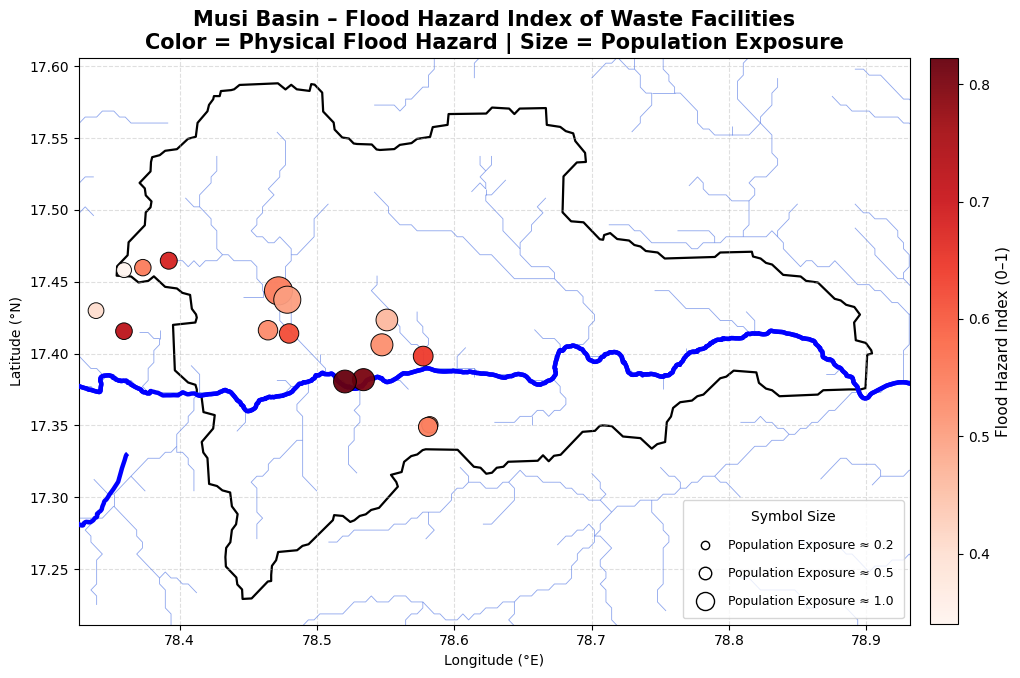

In [82]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# ============================================================
# LOAD FINAL HAZARD + POPULATION DATA
# ============================================================

waste = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/osm/"
    "waste_facilities_flood_hazard_with_population.geojson"
).to_crs(epsg=4326)

basin = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrobasin_08/"
    "musi_basin.shp"
).to_crs(epsg=4326)

rivers = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "hydrorivers_clean.geojson"
).to_crs(epsg=4326)

musi = gpd.read_file(
    "/vol/sandeep_storage/Files2/catastrophe/hydrorivers/"
    "musi.geojson"
).to_crs(epsg=4326)

print("Loaded facilities:", len(waste))

# ============================================================
# MAP EXTENT
# ============================================================

minx, miny, maxx, maxy = basin.total_bounds
pad_x = 0.05 * (maxx - minx)
pad_y = 0.05 * (maxy - miny)

extent = [
    minx - pad_x,
    maxx + pad_x,
    miny - pad_y,
    maxy + pad_y
]

# ============================================================
# FIGURE
# ============================================================

fig, ax = plt.subplots(figsize=(11, 9))

# Basin boundary
basin.boundary.plot(
    ax=ax,
    linewidth=1.6,
    edgecolor="black",
    zorder=1
)

# River network
rivers.plot(
    ax=ax,
    color="royalblue",
    linewidth=0.6,
    alpha=0.6,
    zorder=2
)

# Musi river
musi.plot(
    ax=ax,
    color="blue",
    linewidth=3.2,
    zorder=3,
    label="Musi River"
)

# ============================================================
# WASTE FACILITIES
# ============================================================

norm = mpl.colors.Normalize(
    vmin=waste["flood_hazard_index"].min(),
    vmax=waste["flood_hazard_index"].max()
)

sc = ax.scatter(
    waste.geometry.x,
    waste.geometry.y,
    c=waste["flood_hazard_index"],
    cmap="Reds",
    norm=norm,
    s=60 + 350 * waste["pop_exposure"],
    edgecolor="black",
    linewidth=0.7,
    alpha=0.95,
    zorder=4
)

# ============================================================
# COLORBAR
# ============================================================

cbar = plt.colorbar(sc, ax=ax, shrink=0.65, pad=0.02)
cbar.set_label("Flood Hazard Index (0–1)", fontsize=11)

# ============================================================
# FIXED LEGEND — NON-OVERLAPPING CIRCLES
# ============================================================

size_vals = [0.2, 0.5, 1.0]
size_markers = [6, 9, 13]  # visually scaled

legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=ms,
        markerfacecolor="none",
        markeredgecolor="black",
        label=f"Population Exposure ≈ {val}"
    )
    for val, ms in zip(size_vals, size_markers)
]

ax.legend(
    handles=legend_handles,
    title="Symbol Size",
    loc="lower right",
    frameon=True,
    fontsize=9,
    labelspacing=1.2,
    borderpad=0.8
)

# ============================================================
# AXES & TITLE
# ============================================================

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.grid(True, linestyle="--", alpha=0.4)

ax.set_title(
    "Musi Basin – Flood Hazard Index of Waste Facilities\n"
    "Color = Physical Flood Hazard | Size = Population Exposure",
    fontsize=15,
    weight="bold"
)

plt.tight_layout()
plt.show()


STATIC HAZARD CONDITIONING  Done


---